In [1]:
#@title Install lightweight deps
!pip -q install librosa soundfile numpy pandas tqdm

import os, gc, math
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, soundfile as sf
from tqdm import tqdm
from dataclasses import dataclass

In [2]:
#@title Load project config
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PROJECT_DIR = Path('/content/drive/MyDrive/ddsp-demucs')

import yaml
CFG = yaml.safe_load(open(PROJECT_DIR / 'env' / 'config.yaml'))
STEMS_DIR    = Path(CFG['paths']['stems_dir'])
FEATURES_DIR = Path(CFG['paths']['features_dir'])
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

print("Stems in:", STEMS_DIR)
print("Features out:", FEATURES_DIR)


# Looser gate for a first pass
CFG["gate_thresholds"].update({
    "f0_conf_min": 0.50,
    "harmonicity_ratio_min": 0.50,
    "residual_energy_ratio_max": 0.60,  # this is an upper bound, so higher = more permissive
    "mono_frame_fraction_min": 0.60,
    "mono_track_fraction_min": 0.70,
})

#@title Lean analysis + gating config (RAM-friendly)
@dataclass
class AnalysisConfig:
    # Downsample for feature extraction to cut RAM/CPU
    sr: int = 22050                      # leaner than 44.1k
    frame_hop_s: float = 0.010           # 10 ms
    frame_len_s: float = 0.032           # ~1024 @ 32 ms
    fmin: float = librosa.note_to_hz('C2')
    fmax: float = librosa.note_to_hz('C7')
    # Process audio in small windows
    chunk_s: float = 20.0                # seconds per chunk
    overlap_s: float = 0.50              # 0.5s chunk overlap (avoid edge effects)
    # Harmonic fit settings
    harmonic_tolerance: float = 0.03
    max_harmonics: int = 20

    # Segmenting and thresholds (from config)
    segment_len_s: float = 10.0
    segment_hop_s: float = 5.0
    f0_conf_min: float = CFG['gate_thresholds'].get('f0_conf_min', 0.65)
    harmonicity_ratio_min: float = CFG['gate_thresholds'].get('harmonicity_ratio_min', 0.65)
    residual_energy_ratio_max: float = CFG['gate_thresholds'].get('residual_energy_ratio_max', 0.38)
    mono_frame_fraction_min: float = CFG['gate_thresholds'].get('mono_frame_fraction_min', 0.80)
    mono_track_fraction_min: float = CFG['gate_thresholds'].get('mono_track_fraction_min', 0.88)

AC = AnalysisConfig()
AC

Mounted at /content/drive
Stems in: /content/drive/MyDrive/ddsp-demucs/data/stems/demucs_htdemucs44k
Features out: /content/drive/MyDrive/ddsp-demucs/data/features


AnalysisConfig(sr=22050, frame_hop_s=0.01, frame_len_s=0.032, fmin=np.float64(65.40639132514966), fmax=np.float64(2093.004522404789), chunk_s=20.0, overlap_s=0.5, harmonic_tolerance=0.03, max_harmonics=20, segment_len_s=10.0, segment_hop_s=5.0, f0_conf_min=0.5, harmonicity_ratio_min=0.5, residual_energy_ratio_max=0.6, mono_frame_fraction_min=0.6, mono_track_fraction_min=0.7)

In [3]:
#@title Helpers (streaming read, features, gating)
def frames_to_times(n_frames, hop_s):
    return np.arange(n_frames, dtype=np.float32) * hop_s

def extract_f0_pyin_block(y, sr, hop, frame_len, fmin, fmax):
    f0, vflag, vprob = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr,
                                    frame_length=frame_len, hop_length=hop)
    f0 = np.asarray(f0)
    vprob = np.asarray(vprob)
    conf = np.where(np.isnan(f0), 0.0, np.nan_to_num(vprob, nan=0.0)).astype(np.float32)
    vmask = (~np.isnan(f0))
    f0_hz = np.nan_to_num(f0, nan=0.0).astype(np.float32)
    return f0_hz, conf, vmask

def stft_mag_block(y, sr, n_fft, hop):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=n_fft, window="hann")
    return np.abs(S).astype(np.float32), librosa.fft_frequencies(sr=sr, n_fft=n_fft)

def harmonic_energy_ratio_block(mag, freqs, f0_hz, tol=0.03, max_harm=20):
    F, T = mag.shape
    total = (mag**2).sum(axis=0) + 1e-12
    ratio = np.zeros(T, dtype=np.float32)
    for t in range(T):
        f0 = f0_hz[t]
        if f0 <= 0:
            ratio[t] = 0.0
            continue
        energy_sum = 0.0
        h = 1
        fmax = freqs[-1]*(1.0 - tol)
        while h <= max_harm and h*f0 < fmax:
            target = h * f0
            lo = target * (1.0 - tol)
            hi = target * (1.0 + tol)
            idx = np.where((freqs >= lo) & (freqs <= hi))[0]
            if idx.size > 0:
                energy_sum += float((mag[idx, t]**2).sum())
            h += 1
        ratio[t] = energy_sum / float(total[t])
    residual = 1.0 - ratio
    return ratio.astype(np.float32), residual.astype(np.float32)

def chroma_entropy_stft_block(y, sr, hop, n_fft):
    # lighter than chroma_cqt
    C = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    C = np.maximum(C, 1e-12)
    P = C / C.sum(axis=0, keepdims=True)
    ent = -(P * np.log(P)).sum(axis=0) / np.log(12.0)
    return ent.astype(np.float32)

def rms_block(y, sr, hop, n_fft):
    return librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop).squeeze().astype(np.float32)

def frame_monophony_mask(f0_conf, harm_ratio, residual):
    return (f0_conf >= AC.f0_conf_min) & (harm_ratio >= AC.harmonicity_ratio_min) & (residual <= AC.residual_energy_ratio_max)

def segment_decisions(is_mono_frame, is_voiced_frame, hop_s, seg_len_s, seg_hop_s):
    T = len(is_mono_frame)
    win = int(seg_len_s / hop_s)
    hop = int(seg_hop_s / hop_s)
    out = []
    for start in range(0, max(1, T - win + 1), hop):
        end = min(T, start + win)
        voiced = is_voiced_frame[start:end]
        mono = is_mono_frame[start:end]
        vcnt = int(voiced.sum())
        mcnt = int((mono & voiced).sum())
        frac = (mcnt / vcnt) if vcnt > 0 else 0.0
        out.append({
            "start_s": round(start*hop_s, 3),
            "end_s": round(end*hop_s, 3),
            "voiced_frames": vcnt,
            "mono_voiced_frames": mcnt,
            "mono_fraction": frac,
            "segment_pass": (vcnt > 0) and (frac >= AC.mono_frame_fraction_min),
        })
    return out


In [4]:
#@title Streaming per-track extraction (RAM-safe)
def process_track_streaming(mono_path: Path, out_npz: Path, out_seg_csv: Path):
    # Read basic info without loading all into RAM
    file_info = sf.info(str(mono_path))
    orig_sr = file_info.samplerate
    n_frames_total = file_info.frames

    # Precompute constants
    sr = AC.sr
    n_fft = int(AC.frame_len_s * sr)
    hop   = int(AC.frame_hop_s * sr)
    chunk = int(AC.chunk_s * orig_sr)
    over  = int(AC.overlap_s * orig_sr)

    # Accumulators (small per-frame)
    f0_all, conf_all, vmask_all = [], [], []
    harm_all, resid_all = [], []
    chroma_ent_all, loud_all = [], []

    # Stream blocks with overlap
    start = 0
    with sf.SoundFile(str(mono_path), 'r') as f:
        while start < n_frames_total:
            # Read with overlap at head; seek appropriately
            read_start = max(0, start - over)
            f.seek(read_start)
            to_read = min(chunk + over if start == 0 else chunk + 2*over,
                          n_frames_total - read_start)
            y = f.read(frames=to_read, dtype='float32')  # (frames,) mono already
            if y.ndim > 1:
                y = y.mean(axis=1)

            # Resample this chunk
            if orig_sr != sr:
                y = librosa.resample(y, orig_sr=orig_sr, target_sr=sr)

            # Compute per-chunk features
            f0_hz, f0_conf, vmask = extract_f0_pyin_block(y, sr, hop, n_fft, AC.fmin, AC.fmax)
            mag, freqs = stft_mag_block(y, sr, n_fft, hop)
            harm_ratio, residual = harmonic_energy_ratio_block(mag, freqs, f0_hz,
                                                               tol=AC.harmonic_tolerance,
                                                               max_harm=AC.max_harmonics)
            chroma_ent = chroma_entropy_stft_block(y, sr, hop, n_fft)
            loud = rms_block(y, sr, hop, n_fft)

            # Trim head/tail overlap regions to keep frames unique
            # Convert overlap seconds to frames at analysis hop
            overlap_frames = int(AC.overlap_s / AC.frame_hop_s)
            if start == 0:
                # first block: trim only tail overlap
                sl = slice(0, max(0, len(f0_hz) - overlap_frames))
            else:
                # middle blocks: trim both head and tail
                sl = slice(overlap_frames, max(overlap_frames, len(f0_hz) - overlap_frames))

            f0_all.append(f0_hz[sl]); conf_all.append(f0_conf[sl]); vmask_all.append(vmask[sl])
            harm_all.append(harm_ratio[sl]); resid_all.append(residual[sl])
            chroma_ent_all.append(chroma_ent[sl]); loud_all.append(loud[sl])

            # Advance
            start += chunk
            # Free big arrays
            del y, mag, freqs, f0_hz, f0_conf, vmask, harm_ratio, residual, chroma_ent, loud
            gc.collect()

    # Concatenate
    f0 = np.concatenate(f0_all, axis=0)
    conf = np.concatenate(conf_all, axis=0)
    vmask = np.concatenate(vmask_all, axis=0)
    harmonic = np.concatenate(harm_all, axis=0)
    residual = np.concatenate(resid_all, axis=0)
    chroma_ent = np.concatenate(chroma_ent_all, axis=0)
    loud = np.concatenate(loud_all, axis=0)

    # Align lengths (off-by-1 safety)
    L = min(len(f0), len(conf), len(vmask), len(harmonic), len(residual), len(chroma_ent), len(loud))
    f0, conf, vmask = f0[:L], conf[:L], vmask[:L]
    harmonic, residual = harmonic[:L], residual[:L]
    chroma_ent, loud = chroma_ent[:L], loud[:L]

    hop_s = AC.frame_hop_s
    times = frames_to_times(L, hop_s)
    mono_frame = frame_monophony_mask(conf, harmonic, residual)

    # Segment decisions
    seg_rows = segment_decisions(mono_frame, vmask, hop_s, AC.segment_len_s, AC.segment_hop_s)
    seg_df = pd.DataFrame(seg_rows)
    seg_df.to_csv(out_seg_csv, index=False)

    # Track-level summary
    voiced_total = int(vmask.sum())
    mono_voiced_total = int((mono_frame & vmask).sum())
    mono_track_fraction = (mono_voiced_total / voiced_total) if voiced_total > 0 else 0.0
    track_pass = (voiced_total > 0) and (mono_track_fraction >= AC.mono_track_fraction_min)

    # Save compressed features
    np.savez_compressed(
        out_npz,
        sr=np.int32(sr),
        hop=np.int32(hop),
        times=times.astype(np.float32),
        f0_hz=f0.astype(np.float32),
        f0_conf=conf.astype(np.float32),
        voiced_mask=vmask.astype(np.bool_),
        harmonic_ratio=harmonic.astype(np.float32),
        residual_ratio=residual.astype(np.float32),
        chroma_entropy=chroma_ent.astype(np.float32),
        loudness=loud.astype(np.float32),
    )

    return {
        "sr": sr,
        "hop_s": hop_s,
        "frames": L,
        "voiced_frames": voiced_total,
        "mono_voiced_frames": mono_voiced_total,
        "mono_track_fraction": mono_track_fraction,
        "track_pass": track_pass
    }


In [ ]:
#@title Run streaming extraction + gating over all mono stems
tracks = sorted([p for p in STEMS_DIR.glob("*") if p.is_dir()])
assert tracks, f"No separated tracks found in {STEMS_DIR}"

global_rows = []
for tdir in tqdm(tracks, desc="Streaming features+gate"):
    mono_path = tdir / "vocals.mono.wav"
    if not mono_path.exists():
        continue
    out_npz = FEATURES_DIR / f"{tdir.name}.npz"
    out_seg = FEATURES_DIR / f"{tdir.name}_segments.csv"

    try:
        summary = process_track_streaming(mono_path, out_npz, out_seg)
        global_rows.append({
            "track": tdir.name,
            "sr": summary["sr"],
            "hop_s": round(summary["hop_s"], 4),
            "frames": summary["frames"],
            "voiced_frames": summary["voiced_frames"],
            "mono_voiced_frames": summary["mono_voiced_frames"],
            "mono_track_fraction": summary["mono_track_fraction"],
            "track_pass": summary["track_pass"],
            "features_npz": str(out_npz),
            "segments_csv": str(out_seg),
        })
    except Exception as e:
        print(f"⚠️ Error on {tdir.name}: {e}")

global_csv = FEATURES_DIR / "monophony_decisions.csv"
pd.DataFrame(global_rows).sort_values("track").to_csv(global_csv, index=False)
print("✅ Wrote:", global_csv)

Streaming features+gate:   5%|▌         | 8/151 [25:13<7:03:20, 177.63s/it]/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Streaming features+gate: 100%|██████████| 151/151 [9:53:05<00:00, 235.67s/it]

✅ Wrote: /content/drive/MyDrive/ddsp-demucs/data/features/monophony_decisions.csv


In [ ]:
#@title Pick a track to debug and load its features
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yaml, json, textwrap

PROJECT_DIR = Path('/content/drive/MyDrive/ddsp-demucs')
CFG = yaml.safe_load(open(PROJECT_DIR / 'env' / 'config.yaml'))

FEATURES_DIR = Path(CFG['paths']['features_dir'])
all_npz = sorted(FEATURES_DIR.glob("*.npz"))
assert all_npz, f"No features found in {FEATURES_DIR}. Run the extraction first."

# Pick by name (set to "" to choose random)
track_name_filter = ""  #@param {type:"string"}
if track_name_filter:
    cand = [p for p in all_npz if track_name_filter.lower() in p.stem.lower()]
    assert cand, f"No track matching '{track_name_filter}'"
    feat_path = cand[0]
else:
    feat_path = np.random.choice(all_npz)

seg_path = feat_path.with_name(feat_path.stem + "_segments.csv")
print("Track:", feat_path.stem)
print("Features:", feat_path.name)
print("Segments:", seg_path.name)

D = np.load(feat_path)
times = D["times"]
f0_conf = D["f0_conf"]
harm = D["harmonic_ratio"]
resid = D["residual_ratio"]
vmask = D["voiced_mask"].astype(bool)
loud = D["loudness"]
sr = int(D["sr"]); hop = int(D["hop"])
hop_s = hop / sr

seg_df = pd.read_csv(seg_path)

# Current thresholds
thr = CFG["gate_thresholds"]
f0_thr   = float(thr.get("f0_conf_min", 0.5))
harm_thr = float(thr.get("harmonicity_ratio_min", 0.5))
res_thr  = float(thr.get("residual_energy_ratio_max", 0.5))
seg_min  = float(thr.get("mono_frame_fraction_min", 0.6))
trk_min  = float(thr.get("mono_track_fraction_min", 0.7))

print("Thresholds:",
      f"\n  f0_conf_min={f0_thr}",
      f"\n  harmonicity_ratio_min={harm_thr}",
      f"\n  residual_energy_ratio_max={res_thr}",
      f"\n  mono_frame_fraction_min={seg_min}",
      f"\n  mono_track_fraction_min={trk_min}")



Track: Music Delta - Reggae
Features: Music Delta - Reggae.npz
Segments: Music Delta - Reggae_segments.csv
Thresholds: 
  f0_conf_min=0.65 
  harmonicity_ratio_min=0.65 
  residual_energy_ratio_max=0.38 
  mono_frame_fraction_min=0.8 
  mono_track_fraction_min=0.88


Mono track fraction (voiced): 0.104 | PASS: False


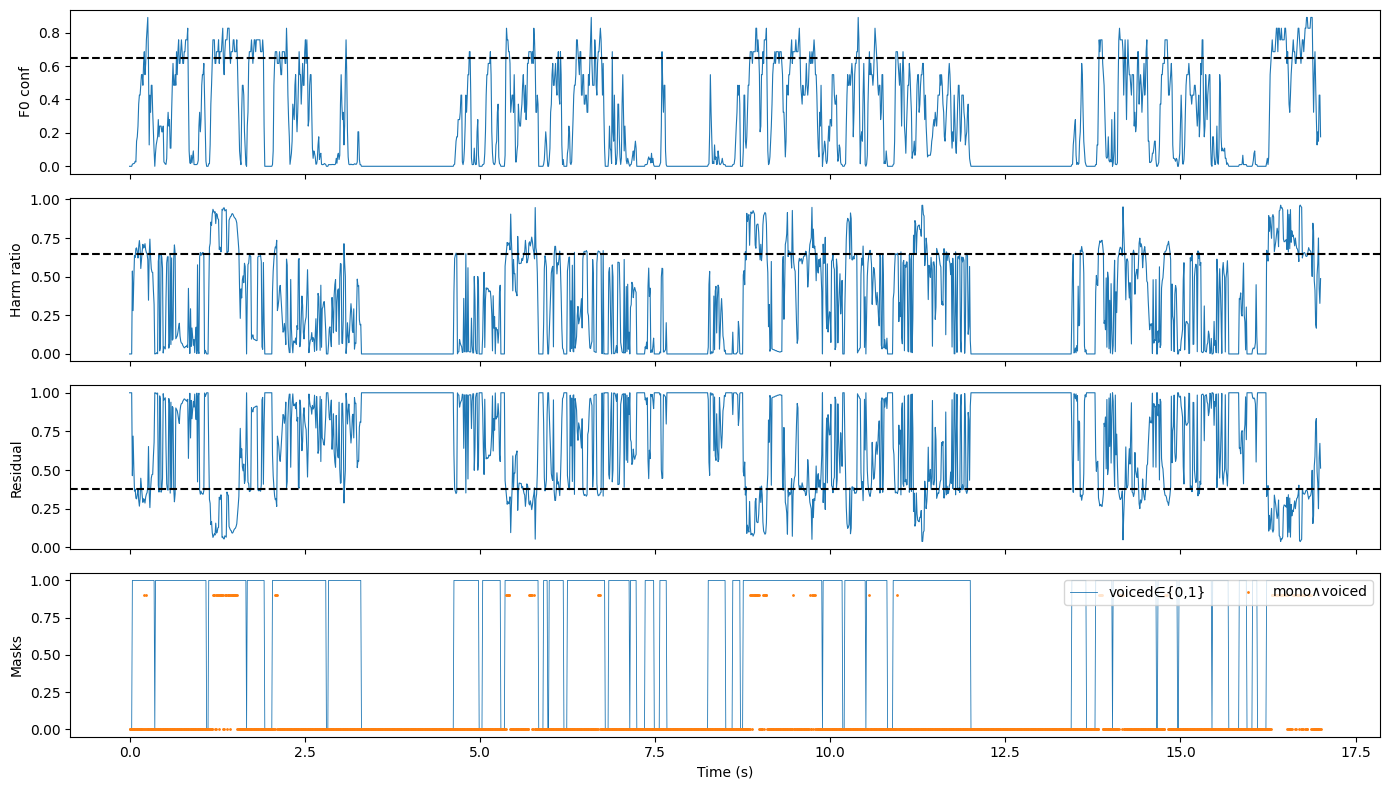

In [ ]:
#@title Time-series preview with thresholds and voiced mask
mono_frame = (f0_conf >= f0_thr) & (harm >= harm_thr) & (resid <= res_thr)
mono_voiced = mono_frame & vmask

mono_track_fraction = (mono_voiced.sum() / max(1, vmask.sum()))
print(f"Mono track fraction (voiced): {mono_track_fraction:.3f} | PASS: {mono_track_fraction >= trk_min}")

fig, axs = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
axs[0].plot(times, f0_conf, lw=0.8); axs[0].axhline(f0_thr, color='k', ls='--'); axs[0].set_ylabel("F0 conf")
axs[1].plot(times, harm, lw=0.8); axs[1].axhline(harm_thr, color='k', ls='--'); axs[1].set_ylabel("Harm ratio")
axs[2].plot(times, resid, lw=0.8); axs[2].axhline(res_thr, color='k', ls='--'); axs[2].set_ylabel("Residual")
axs[3].plot(times, vmask.astype(float), lw=0.6, label="voiced∈{0,1}")
axs[3].plot(times, mono_voiced.astype(float)*0.9, lw=0, marker='.', ms=2, label="mono∧voiced")
axs[3].set_ylabel("Masks"); axs[3].legend(loc='upper right', ncol=2)
axs[-1].set_xlabel("Time (s)")
plt.tight_layout(); plt.show()


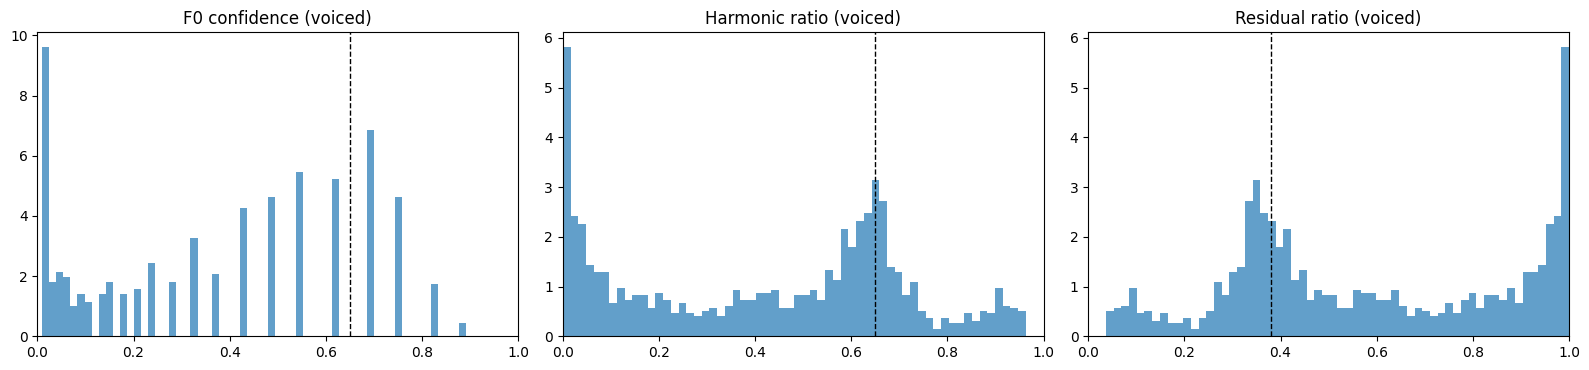

In [ ]:
#@title Histograms of key features (voiced frames only)
sel = vmask
def hist_with_cut(ax, data, thr=None, title="", bins=60, xlim=(0,1)):
    ax.hist(data, bins=bins, density=True, alpha=0.7)
    if thr is not None: ax.axvline(thr, color='k', ls='--', lw=1)
    ax.set_xlim(*xlim); ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(16, 3.8))
hist_with_cut(axs[0], f0_conf[sel], f0_thr, "F0 confidence (voiced)")
hist_with_cut(axs[1], harm[sel],     harm_thr, "Harmonic ratio (voiced)")
hist_with_cut(axs[2], resid[sel],    res_thr,  "Residual ratio (voiced)")
plt.tight_layout(); plt.show()


Segments: 2 | Passed: 0 | Voiced coverage by passed segments: 0.000


,start_s,end_s,voiced_frames,mono_voiced_frames,mono_fraction,segment_pass
0,0.0,10.0,720,159,0.220833,False
1,5.0,15.0,702,161,0.229345,False


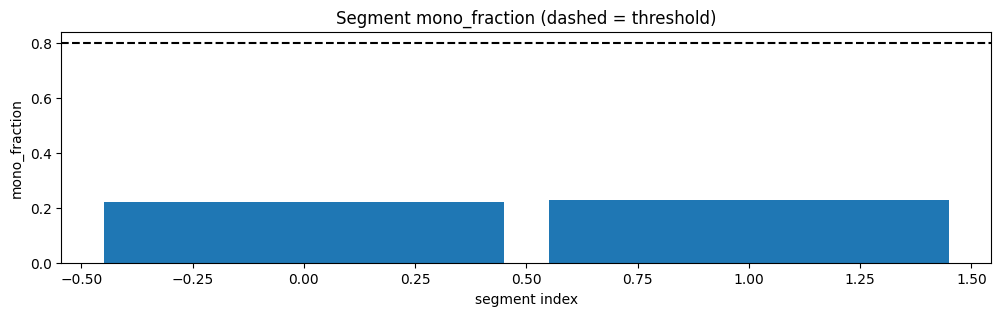

In [ ]:
#@title Segment pass/fail summary
passed = seg_df[seg_df.segment_pass]
coverage = 0.0
if seg_df.voiced_frames.sum() > 0:
    coverage = passed.voiced_frames.sum() / seg_df.voiced_frames.sum()

print(f"Segments: {len(seg_df)} | Passed: {len(passed)} | Voiced coverage by passed segments: {coverage:.3f}")
display(seg_df.head(10))

# Simple bar of mono_fraction across segments
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.bar(np.arange(len(seg_df)), seg_df.mono_fraction.values, width=0.9)
plt.axhline(seg_min, color='k', ls='--')
plt.ylabel("mono_fraction"); plt.xlabel("segment index")
plt.title("Segment mono_fraction (dashed = threshold)")
plt.show()


In [ ]:
#@title Sweep thresholds to find a sweet spot
def sweep(f0_vals, harm_vals, resid_vals, vmask, seg_len_s, seg_hop_s, hop_s,
          f0_grid, harm_grid, resid_grid, seg_min_grid):
    # minimal re-implementation of segment decisions to keep this cell self-contained
    def seg_pass(fr_mask, vm):
        T = len(fr_mask); win = int(seg_len_s/hop_s); hop = int(seg_hop_s/hop_s)
        keep = []
        for st in range(0, max(1, T-win+1), hop):
            ed = min(T, st+win)
            vcnt = int(vm[st:ed].sum())
            mcnt = int((fr_mask[st:ed] & vm[st:ed]).sum())
            frac = (mcnt/vcnt) if vcnt>0 else 0.0
            keep.append(frac >= seg_min)
        return np.array(keep, bool)

    results = []
    for fthr in f0_grid:
        for hthr in harm_grid:
            for rthr in resid_grid:
                mono_frame = (f0_vals >= fthr) & (harm_vals >= hthr) & (resid_vals <= rthr)
                # segment pass vector (bool per segment)
                # compute coverage = voiced frames inside passing segments / total voiced frames
                T = len(mono_frame); win = int(seg_len_s/hop_s); hop = int(seg_hop_s/hop_s)
                voiced_total = int(vmask.sum())
                voiced_kept = 0
                for st in range(0, max(1, T-win+1), hop):
                    ed = min(T, st+win)
                    vcnt = int(vmask[st:ed].sum())
                    if vcnt == 0:
                        continue
                    mfrac = int((mono_frame[st:ed] & vmask[st:ed]).sum())/vcnt
                    if mfrac >= seg_min_grid:
                        voiced_kept += vcnt
                coverage = (voiced_kept/voiced_total) if voiced_total>0 else 0.0
                results.append((fthr, hthr, rthr, seg_min_grid, coverage))
    return pd.DataFrame(results, columns=["f0_conf_min","harm_min","res_max","seg_min","coverage"])

# grids (start coarse; refine after a glance)
f0_grid   = np.linspace(0.4, 0.7, 4)   # 0.40, 0.50, 0.60, 0.70
harm_grid = np.linspace(0.4, 0.7, 4)
res_grid  = np.linspace(0.4, 0.7, 4)   # this is an upper bound
seg_grid  = seg_min  # keep fixed first; change if needed

sweep_df = sweep(f0_conf[vmask], harm[vmask], resid[vmask], vmask,
                 seg_len_s=CFG["gate_thresholds"].get("segment_len_s", 10.0),
                 seg_hop_s=CFG["gate_thresholds"].get("segment_hop_s", 5.0) if "segment_hop_s" in CFG["gate_thresholds"] else 5.0,
                 hop_s=hop_s,
                 f0_grid=f0_grid, harm_grid=harm_grid, resid_grid=res_grid, seg_min_grid=seg_grid)

sweep_df = sweep_df.sort_values("coverage", ascending=False)
display(sweep_df.head(10))


,f0_conf_min,harm_min,res_max,seg_min,coverage
0,0.4,0.4,0.4,0.8,0.0
1,0.4,0.4,0.5,0.8,0.0
2,0.4,0.4,0.6,0.8,0.0
3,0.4,0.4,0.7,0.8,0.0
4,0.4,0.5,0.4,0.8,0.0
5,0.4,0.5,0.5,0.8,0.0
6,0.4,0.5,0.6,0.8,0.0
7,0.4,0.5,0.7,0.8,0.0
8,0.4,0.6,0.4,0.8,0.0
9,0.4,0.6,0.5,0.8,0.0


In [ ]:
#@title Update thresholds in env/config.yaml (optional)
new_f0   = float(sweep_df.iloc[0].f0_conf_min)
new_harm = float(sweep_df.iloc[0].harm_min)
new_res  = float(sweep_df.iloc[0].res_max)
new_seg  = float(sweep_df.iloc[0].seg_min)

print("Proposed thresholds:",
      f"\n  f0_conf_min={new_f0}",
      f"\n  harmonicity_ratio_min={new_harm}",
      f"\n  residual_energy_ratio_max={new_res}",
      f"\n  mono_frame_fraction_min={new_seg}")

Proposed thresholds: 
  f0_conf_min=0.4 
  harmonicity_ratio_min=0.4 
  residual_energy_ratio_max=0.4 
  mono_frame_fraction_min=0.8


## Percentile Segmenting

In [11]:
from pathlib import Path
import numpy as np, pandas as pd, yaml

# --- Paths ---
PROJECT_DIR = Path('/content/drive/MyDrive/ddsp-demucs')
CFG = yaml.safe_load(open(PROJECT_DIR / 'env' / 'config.yaml'))
FEATURES_DIR = Path(CFG['paths']['features_dir'])

# --- Quick gate params (tune for recall first) ---
GLOBAL_TOP_PERCENT = 0.35   # keep top 40% of voiced frames globally
SEG_LEN_S = 6.0             # shorter segments improve locality
SEG_HOP_S = 3.0
SEG_MIN = 0.55              # segment passes if >=55% kept frames among voiced
USE_GLOBAL = True           # True: one global percentile • False: per-track percentile
Z_NORMALIZE = True          # z-norm each component before combining

# --- Load features (voiced frames only), compute global stats if needed ---
npzs = sorted(FEATURES_DIR.glob("*.npz"))
assert npzs, f"No features found in {FEATURES_DIR}."

all_scores = []
track_meta = []

def combine_score(f0c, harm, resid, z_norm=True):
    # Stack and z-normalize (per-array) to balance scales
    X = np.stack([f0c, harm, -resid], axis=0)  # residual enters with minus sign
    if z_norm:
        X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
    return X.mean(axis=0)  # simple average; could weight if you like

# First pass: gather global scores (voiced only)
for npz in npzs:
    D = np.load(npz)
    vmask = D["voiced_mask"].astype(bool)
    f0c, harm, resid = D["f0_conf"][vmask], D["harmonic_ratio"][vmask], D["residual_ratio"][vmask]
    if f0c.size == 0:
        continue
    sc = combine_score(f0c, harm, resid, z_norm=Z_NORMALIZE)
    all_scores.append(sc)
    track_meta.append({
        "name": npz.stem,
        "sr": int(D["sr"]),
        "hop": int(D["hop"]),
        "vmask_len": int(vmask.sum())
    })

if USE_GLOBAL and len(all_scores) > 0:
    global_scores = np.concatenate(all_scores)
    tau = np.quantile(global_scores, 1.0 - GLOBAL_TOP_PERCENT)  # threshold
else:
    tau = None  # per-track mode will compute its own

print("Global threshold (tau):", None if tau is None else float(tau))

# --- Helper: segment decisions given a kept-frame mask ---
def segment_decisions(keep_mask, voiced_mask, hop_s, seg_len_s, seg_hop_s, seg_min):
    T = len(keep_mask)
    win = int(round(seg_len_s / hop_s))
    hop = int(round(seg_hop_s / hop_s))
    rows = []
    for st in range(0, max(1, T - win + 1), hop):
        ed = min(T, st + win)
        vcnt = int(voiced_mask[st:ed].sum())
        if vcnt == 0:
            frac = 0.0
        else:
            frac = float((keep_mask[st:ed] & voiced_mask[st:ed]).sum()) / vcnt
        rows.append({
            "start_s": st * hop_s,
            "end_s": ed * hop_s,
            "mono_fraction": frac,
            "segment_pass": (vcnt > 0) and (frac >= seg_min),
            "voiced_frames": vcnt
        })
    return pd.DataFrame(rows)

# --- Second pass: per-track gating & summaries ---
sum_rows = []
seg_rows = []

for npz in npzs:
    D = np.load(npz)
    times = D["times"]; sr = int(D["sr"]); hop = int(D["hop"]); hop_s = hop / sr
    vmask = D["voiced_mask"].astype(bool)
    f0c, harm, resid = D["f0_conf"], D["harmonic_ratio"], D["residual_ratio"]

    if vmask.sum() == 0:
        sum_rows.append({"track": npz.stem, "sr": sr, "hop_s": hop_s,
                         "voiced_frames": 0, "kept_frames": 0,
                         "kept_fraction": 0.0, "segments_passed": 0,
                         "voiced_coverage_passed": 0.0})
        continue

    score = combine_score(f0c, harm, resid, z_norm=Z_NORMALIZE)

    # Threshold: global or per-track percentile
    if USE_GLOBAL:
        th = tau
    else:
        # Keep top X% voiced frames in THIS track
        sc_voiced = score[vmask]
        th = np.quantile(sc_voiced, 1.0 - GLOBAL_TOP_PERCENT)

    keep_frame = np.zeros_like(score, dtype=bool)
    keep_frame[vmask] = (score[vmask] >= th)

    # Segment-level decisions
    seg_df = segment_decisions(keep_frame, vmask, hop_s, SEG_LEN_S, SEG_HOP_S, SEG_MIN)
    seg_df["track"] = npz.stem
    seg_rows.append(seg_df)

    # Summaries
    voiced_total = int(vmask.sum())
    kept_total = int((keep_frame & vmask).sum())
    passed = seg_df[seg_df.segment_pass]
    coverage = 0.0
    if seg_df.voiced_frames.sum() > 0:
        coverage = passed.voiced_frames.sum() / seg_df.voiced_frames.sum()

    sum_rows.append({
        "track": npz.stem,
        "sr": sr,
        "hop_s": hop_s,
        "voiced_frames": voiced_total,
        "kept_frames": kept_total,
        "kept_fraction": (kept_total / voiced_total) if voiced_total > 0 else 0.0,
        "segments_passed": int(passed.shape[0]),
        "voiced_coverage_passed": coverage
    })

# --- Write outputs ---
summary_df = pd.DataFrame(sum_rows).sort_values(["voiced_coverage_passed","kept_fraction"], ascending=False)
summary_csv = FEATURES_DIR / "monophony_decisions_quick.csv"
summary_df.to_csv(summary_csv, index=False)

segs_df = pd.concat(seg_rows, ignore_index=True) if seg_rows else pd.DataFrame()
segs_csv = FEATURES_DIR / "accepted_segments_quick.csv"
segs_df.to_csv(segs_csv, index=False)

print("✅ Wrote:", summary_csv)
print("✅ Wrote:", segs_csv)
print("Top 5 tracks by voiced coverage:")
display(summary_df.head(5))


Global threshold (tau): 0.42802324891090393
✅ Wrote: /content/drive/MyDrive/ddsp-demucs/data/features/monophony_decisions_quick.csv
✅ Wrote: /content/drive/MyDrive/ddsp-demucs/data/features/accepted_segments_quick.csv
Top 5 tracks by voiced coverage:


,track,sr,hop_s,voiced_frames,kept_frames,kept_fraction,segments_passed,voiced_coverage_passed
89,Music Delta - Punk,22050,0.009977,1727,1101,0.637522,8,1.000000
88,Music Delta - Hendrix,22050,0.009977,1283,812,0.632892,5,1.000000
47,Girls Under Glass - We Feel Alright,22050,0.009977,4579,3854,0.841668,48,0.991253
65,Juliet's Rescue - Heartbeats,22050,0.009977,13556,9575,0.706329,67,0.988213
53,Hollow Ground - Left Blind,22050,0.009977,1471,1348,0.916383,37,0.987528


In [12]:
# Ensure at least QUOTA_S seconds per track, per-track percentile fallback.
QUOTA_S = 45.0
MIN_PERCENT = 0.5   # don't go below keeping top 50% voiced
per_track_rows = []

quota_segments = []

for npz in npzs:
    D = np.load(npz)
    sr = int(D["sr"]); hop = int(D["hop"]); hop_s = hop / sr
    vmask = D["voiced_mask"].astype(bool)
    if vmask.sum() == 0:
        continue
    f0c, harm, resid = D["f0_conf"], D["harmonic_ratio"], D["residual_ratio"]
    score = combine_score(f0c, harm, resid, z_norm=Z_NORMALIZE)

    # start from global tau; relax stepwise if quota not met
    perc = 1.0 - GLOBAL_TOP_PERCENT
    kept_sec = 0.0
    best_segs = None
    while perc >= MIN_PERCENT and kept_sec < QUOTA_S:
        th = np.quantile(score[vmask], perc)
        keep_frame = np.zeros_like(score, dtype=bool); keep_frame[vmask] = (score[vmask] >= th)
        seg_df = segment_decisions(keep_frame, vmask, hop_s, SEG_LEN_S, SEG_HOP_S, SEG_MIN)
        passed = seg_df[seg_df.segment_pass]
        kept_sec = float((passed["end_s"] - passed["start_s"]).sum())
        if kept_sec >= QUOTA_S or perc <= MIN_PERCENT:
            best_segs = passed.copy()
            break
        perc -= 0.05  # relax by 5 percentage points

    kept_fraction = (keep_frame & vmask).sum() / max(1, vmask.sum())
    per_track_rows.append({
        "track": npz.stem,
        "percentile_used": perc,
        "kept_fraction": kept_fraction,
        "kept_seconds": kept_sec
    })
    if best_segs is not None and len(best_segs):
        tmp = best_segs.copy(); tmp["track"] = npz.stem
        quota_segments.append(tmp)

quota_df = pd.DataFrame(per_track_rows).sort_values("kept_seconds", ascending=False)
quota_csv = FEATURES_DIR / "accepted_segments_quota.csv"
quota_df.to_csv(quota_csv, index=False)
print("✅ Wrote:", quota_csv)
if quota_segments:
    pd.concat(quota_segments, ignore_index=True).to_csv(FEATURES_DIR / "accepted_segments_quota_detail.csv", index=False)
    print("✅ Wrote:", FEATURES_DIR / "accepted_segments_quota_detail.csv")
display(quota_df.head(10))


✅ Wrote: /content/drive/MyDrive/ddsp-demucs/data/features/accepted_segments_quota.csv
✅ Wrote: /content/drive/MyDrive/ddsp-demucs/data/features/accepted_segments_quota_detail.csv


,track,percentile_used,kept_fraction,kept_seconds
113,Skelpolu - Resurrection,0.65,0.349975,191.883900
46,Georgia Wonder - Siren,0.65,0.349997,185.887528
122,Sweet Lights - You Let Me Down,0.65,0.350022,161.902041
112,Skelpolu - Human Mistakes,0.65,0.350035,149.909297
139,Traffic Experiment - Once More (With Feeling),0.65,0.350003,143.912925
123,Swinging Steaks - Lost My Way,0.65,0.350034,125.923810
114,Skelpolu - Together Alone,0.65,0.350017,119.927438
73,M.E.R.C. Music - Knockout,0.55,0.450017,119.927438
33,Creepoid - OldTree,0.65,0.350018,113.931066
11,Alexander Ross - Velvet Curtain,0.65,0.350016,95.941950


In [10]:
quota_df.tail(30)

,track,percentile_used,kept_fraction,kept_seconds
10,Alexander Ross - Goodbye Bolero,0.60,0.400040,47.970975
98,Patrick Talbot - A Reason To Leave,0.55,0.450032,47.970975
130,The Mountaineering Club - Mallory,0.60,0.400060,47.970975
50,Helado Negro - Mitad Del Mundo,0.55,0.449984,47.970975
147,Young Griffo - Blood To Bone,0.60,0.399978,47.970975
41,Fergessen - Back From The Start,0.60,0.400132,47.970975
145,Wall Of Death - Femme,0.55,0.449825,47.970975
102,Punkdisco - Oral Hygiene,0.60,0.400036,47.970975
94,Night Panther - Fire,0.60,0.400015,47.970975
68,Leaf - Wicked,0.55,0.450014,47.970975
